In [27]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

%matplotlib inline

curr_dir = os.getcwd()

In [2]:
data = np.load('mfcc_data_filtered.npy', allow_pickle=True)

In [3]:
data.shape

(435, 3)

In [4]:
# Convert back to float32
for i in range(data.shape[0]):
    data[i][0] = data[i][0].astype('float32')

In [5]:
time_lengths = [data[i][2] for i in range(data.shape[0])]

In [6]:
time_lengths = np.asarray(time_lengths)

In [7]:
np.min(time_lengths)

232

In [8]:
labels = list(pd.value_counts(data[:,1]).axes[0])
#labels = list(set([data[i][1] for i in range(data.shape[0])]))
labels

['Vireo griseus',
 'Thryothorus ludovicianus',
 'Pitangus sulphuratus',
 'Baeolophus atricristatus',
 'Poecile carolinensis',
 'Passerina ciris',
 'Toxostoma longirostre',
 'Mimus polyglottos',
 'Vireo atricapilla',
 'Myiarchus cinerascens',
 'Catherpes mexicanus',
 'Spiza americana',
 'Aphelocoma wollweberi',
 'Setophaga chrysoparia',
 'Tyrannus forficatus',
 'Piranga rubra',
 'Leiothlypis crissalis',
 'Thryomanes bewickii',
 'Peucaea cassinii',
 'Sturnella magna',
 'Setophaga dominica',
 'Cardinalis cardinalis',
 'Melanerpes aurifrons',
 'Cyanocorax luxuosus',
 'Cyanocitta cristata',
 'Vireo bellii',
 'Spizella atrogularis',
 'Turdus grayi',
 'Rallus elegans',
 'Tympanuchus pallidicinctus',
 'Numenius americanus',
 'Tyrannus couchii',
 'Setophaga citrina',
 'Melanerpes erythrocephalus',
 'Geothlypis trichas',
 'Icteria virens',
 'Arremonops rufivirgatus',
 'Polioptila caerulea',
 'Peucaea aestivalis',
 'Aimophila ruficeps',
 'Glaucidium brasilianum',
 'Setophaga pitiayumi',
 'Quiscal

In [9]:
# 45 classes
len(labels)

45

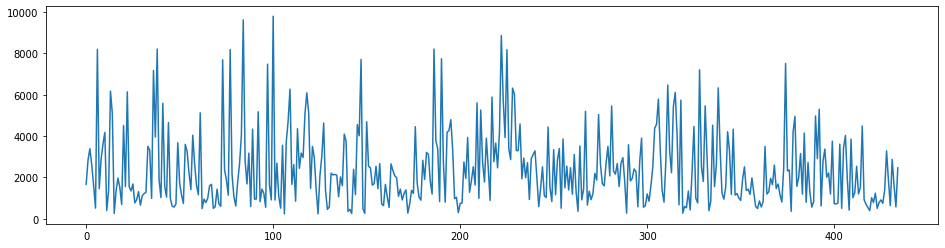

In [11]:
plt.figure(figsize=(16,4))
plt.plot(time_lengths)

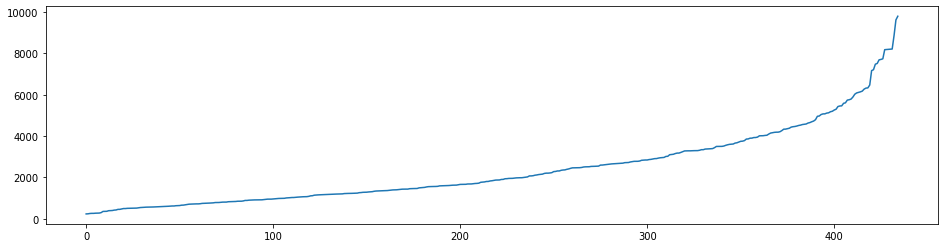

In [12]:
plt.figure(figsize=(16,4))
plt.plot(sorted(time_lengths))

In [10]:
# Reworking this...
# 80 - 20 split
train_sample_indices = np.random.choice([x for x in range(data.shape[0])], 
                                        int(0.8*data.shape[0]), replace=False)
#print(train_sample_indices)
validation_sample_indices = np.random.choice(list(set([x for x in range(data.shape[0])]) - set(train_sample_indices)), 
                                       int(0.2*data.shape[0]), replace=False)
#print(validation_sample_indices)

In [11]:
# Puts together all the generators from before
def data_generator(data, labels, indices, data_lengths, steps=100, samples=None, to_4d=False):
    # Number of testing examples per step
    total_data_length = sum([data_lengths[indices[i]] for i in range(len(indices))])
    if samples is None:
        samples = len(indices)
    #steps = 500
    while True:
        # Sample a set of training indices
        # With probability given by the proportion of time each recording takes in the total time
        # This samples the periods of time uniformly, as if all recordings were back-to-back
        inds = np.random.choice(indices, samples, replace=True, 
                                p=[data_lengths[indices[i]]/total_data_length for i in range(len(indices))])
        # Then for each one sample a segment uniformly
        start_times = [np.random.randint(0, data_lengths[inds[i]]-steps) for i in range(samples)]
        # Then select that part of the feature data and labels
        x = np.asarray([data[inds[i],0][start_times[i]:(start_times[i]+steps),:] for i in range(samples)])
        if to_4d:
            x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
        y = np.asarray([labels.index(data[inds[i],1]) for i in range(samples)])
        yield x, y

In [12]:
full_generator = data_generator(data, labels, [i for i in range(data.shape[0])], time_lengths, steps=200, samples=300, to_4d=False)
train_generator = data_generator(data, labels, train_sample_indices, time_lengths, steps=200, samples=300, to_4d=False)
validation_generator = data_generator(data, labels, validation_sample_indices, time_lengths, steps=200, samples=300, to_4d=False)

In [13]:
model = tf.keras.Sequential()
model.add(layers.LSTM(64, input_shape=(200,22)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(45, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                22272     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                5805      
Total params: 36,397
Trainable params: 36,397
Non-trainable params: 0
_________________________________________________________________


In [59]:
#es = [callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=20)]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 100 steps
Epoch 1/20
100/100 [==============================] - 6s 65ms/step - loss: 3.7358 - accuracy: 0.0499 - val_loss: 3.7001 - val_accuracy: 0.0405
Epoch 2/20
100/100 [==============================] - 4s 42ms/step - loss: 3.5152 - accuracy: 0.0928 - val_loss: 3.5574 - val_accuracy: 0.0735
Epoch 3/20
100/100 [==============================] - 4s 42ms/step - loss: 3.3059 - accuracy: 0.1283 - val_loss: 3.3809 - val_accuracy: 0.0915
Epoch 4/20
100/100 [==============================] - 4s 43ms/step - loss: 3.0759 - accuracy: 0.1765 - val_loss: 3.1363 - val_accuracy: 0.1639
Epoch 5/20
100/100 [==============================] - 4s 42ms/step - loss: 2.8501 - accuracy: 0.2242 - val_loss: 2.9528 - val_accuracy: 0.2104
Epoch 6/20
100/100 [==============================] - 4s 42ms/step - loss: 2.6709 - accuracy: 0.2625 - val_loss: 2.8678 - val_accuracy: 0.2285
Epoch 7/20
100/100 [============================

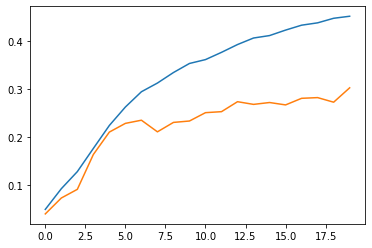

In [14]:
history = model.fit(train_generator, validation_data=validation_generator,
         steps_per_epoch=100, epochs=20, validation_steps=100, callbacks=None)
model.evaluate(validation_generator, steps=200)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

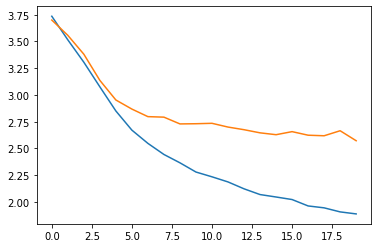

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 200 steps
Epoch 1/30
300/300 [==============================] - 11s 38ms/step - loss: 1.8352 - accuracy: 0.4657 - val_loss: 2.6187 - val_accuracy: 0.2963
Epoch 2/30
300/300 [==============================] - 11s 38ms/step - loss: 1.7793 - accuracy: 0.4792 - val_loss: 2.5494 - val_accuracy: 0.3082
Epoch 3/30
300/300 [==============================] - 11s 38ms/step - loss: 1.7154 - accuracy: 0.4947 - val_loss: 2.5091 - val_accuracy: 0.3113
Epoch 4/30
300/300 [==============================] - 11s 37ms/step - loss: 1.6754 - accuracy: 0.5048 - val_loss: 2.5296 - val_accuracy: 0.3104
Epoch 5/30
300/300 [==============================] - 11s 37ms/step - loss: 1.6256 - accuracy: 0.5196 - val_loss: 2.5405 - val_accuracy: 0.2977
Epoch 6/30
300/300 [==============================] - 11s 37ms/step - loss: 1.5932 - accuracy: 0.5274 - val_loss: 2.5575 - val_accuracy: 0.3229
Epoch 7/30
300/300 [======================

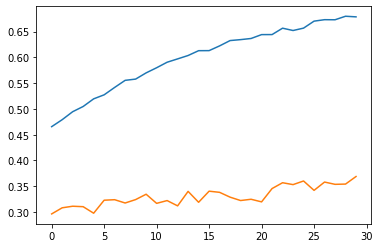

In [16]:
history = model.fit(train_generator, validation_data=validation_generator,
         steps_per_epoch=300, epochs=30, validation_steps=200, callbacks=None)
model.evaluate(validation_generator, steps=300)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [17]:
model.save("m37.h5")

In [18]:
# Attempt to render a confusion matrix by random sampling
confusion_matrix = np.zeros((len(labels), len(labels)))
print(confusion_matrix.shape)

(45, 45)


In [185]:
# To do: 
# Create a stratified random sample for the validation set so that the classes are more balanced.

In [22]:
for _ in range(200):
    pred_data = validation_generator.__next__()
    pred = model.predict(pred_data[0], steps=1)
    for i in range(pred.shape[0]):
        predval = np.argmax(pred[i,:])
        actual = pred_data[1][i]
        confusion_matrix[actual,predval] += 1

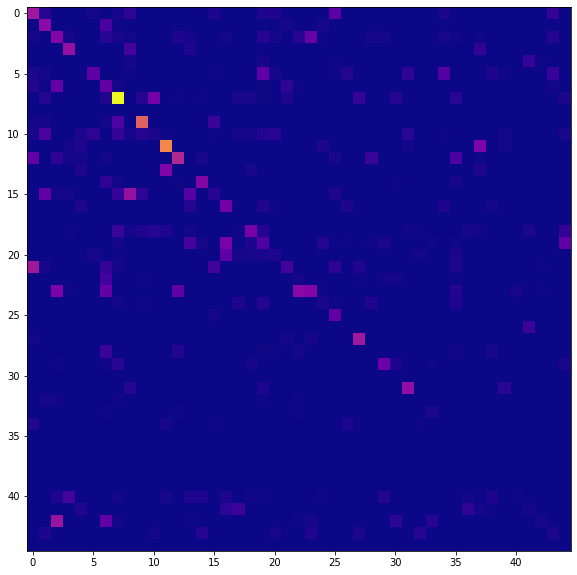

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix, cmap='plasma')

In [21]:
# How well-stratified is the validation set?
vc_train = pd.value_counts([data[train_sample_indices[i],1] for i in range(len(train_sample_indices))])
print(vc_train)
print(len(vc_train))
vc_validation = pd.value_counts([data[validation_sample_indices[i],1] for i in range(len(validation_sample_indices))])
print(vc_validation)
print(len(vc_validation))

Thryothorus ludovicianus      17
Baeolophus atricristatus      17
Poecile carolinensis          14
Vireo griseus                 14
Vireo atricapilla             13
Pitangus sulphuratus          12
Toxostoma longirostre         11
Thryomanes bewickii           11
Tyrannus forficatus           10
Passerina ciris               10
Mimus polyglottos             10
Setophaga chrysoparia          9
Leiothlypis crissalis          9
Catherpes mexicanus            9
Myiarchus cinerascens          9
Melanerpes aurifrons           8
Setophaga dominica             8
Aphelocoma wollweberi          8
Spiza americana                8
Sturnella magna                8
Cyanocitta cristata            7
Piranga rubra                  7
Spizella atrogularis           7
Numenius americanus            7
Vireo bellii                   7
Cardinalis cardinalis          6
Setophaga citrina              6
Melanerpes erythrocephalus     6
Peucaea cassinii               6
Rallus elegans                 6
Tympanuchu

In [28]:
# The training data contains all classes, but the test data is missing some classes...
# I should probably use stratified sampling to pick the validation indices.
model = load_model("m37.h5")

In [58]:
model2 = tf.keras.Sequential()
model2.add(layers.Conv2D(64, (11,1), activation='relu', input_shape=(200, 22, 1))) # 190 x 22
model2.add(layers.Conv2D(48, (11,1), activation='relu')) # 180 x 22
model2.add(layers.MaxPooling2D((2,1))) # 90 x 22
model2.add(layers.Conv2D(32, (11,1), activation='relu')) # 80 x 22
model2.add(layers.MaxPooling2D((2,1))) # 40 x 22
model2.add(layers.Conv2D(16, (11,1), activation='relu')) # 30 x 22
model2.add(layers.Conv2D(8, (11,1), activation='relu')) # 20 x 22
model2.add(layers.MaxPooling2D((2,1))) # 10 x 22
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(45, activation='softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 190, 22, 64)       768       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 180, 22, 48)       33840     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 90, 22, 48)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 80, 22, 32)        16928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 40, 22, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 22, 16)        5648      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 20, 22, 8)       

In [79]:
full_generator = data_generator(data, labels, [i for i in range(data.shape[0])], time_lengths, steps=100, samples=300, to_4d=True)
train_generator = data_generator(data, labels, train_sample_indices, time_lengths, steps=100, samples=300, to_4d=True)
validation_generator = data_generator(data, labels, validation_sample_indices, time_lengths, steps=100, samples=300, to_4d=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 10 steps
Epoch 1/100
20/20 [==============================] - 9s 433ms/step - loss: 4.2473 - accuracy: 0.0418 - val_loss: 3.7045 - val_accuracy: 0.0430
Epoch 2/100
20/20 [==============================] - 8s 409ms/step - loss: 3.5480 - accuracy: 0.0955 - val_loss: 3.5593 - val_accuracy: 0.1100
Epoch 3/100
20/20 [==============================] - 8s 409ms/step - loss: 3.1823 - accuracy: 0.1887 - val_loss: 3.4855 - val_accuracy: 0.1600
Epoch 4/100
20/20 [==============================] - 8s 408ms/step - loss: 2.8521 - accuracy: 0.2705 - val_loss: 3.4628 - val_accuracy: 0.1633
Epoch 5/100
20/20 [==============================] - 8s 408ms/step - loss: 2.5586 - accuracy: 0.3225 - val_loss: 3.3723 - val_accuracy: 0.1893
Epoch 6/100
20/20 [==============================] - 8s 407ms/step - loss: 2.3242 - accuracy: 0.3717 - val_loss: 3.1725 - val_accuracy: 0.2310
Epoch 7/100
20/20 [==============================]

20/20 [==============================] - 8s 415ms/step - loss: 0.5714 - accuracy: 0.8153 - val_loss: 4.4610 - val_accuracy: 0.3807
Epoch 57/100
20/20 [==============================] - 8s 415ms/step - loss: 0.5873 - accuracy: 0.8130 - val_loss: 5.0056 - val_accuracy: 0.3783
Epoch 58/100
20/20 [==============================] - 8s 415ms/step - loss: 0.5832 - accuracy: 0.8070 - val_loss: 4.8755 - val_accuracy: 0.3617
Epoch 59/100
20/20 [==============================] - 8s 416ms/step - loss: 0.5827 - accuracy: 0.8133 - val_loss: 5.3057 - val_accuracy: 0.3620
Epoch 60/100
20/20 [==============================] - 8s 415ms/step - loss: 0.5643 - accuracy: 0.8112 - val_loss: 4.6440 - val_accuracy: 0.3850
Epoch 61/100
20/20 [==============================] - 8s 415ms/step - loss: 0.5755 - accuracy: 0.8083 - val_loss: 4.7810 - val_accuracy: 0.3677
Epoch 62/100
20/20 [==============================] - 8s 417ms/step - loss: 0.5618 - accuracy: 0.8138 - val_loss: 4.3045 - val_accuracy: 0.3873
Epoch

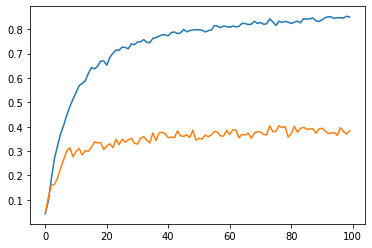

In [59]:
history = model2.fit(train_generator, validation_data=validation_generator,
                     steps_per_epoch=20, epochs=100, validation_steps=10, callbacks=None)
model2.evaluate(validation_generator, steps=50)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [60]:
model2.save('m39.h5')

In [75]:
model3 = tf.keras.Sequential()
model3.add(layers.LSTM(72, input_shape=(200,22)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(45, activation='softmax'))
model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 72)                27360     
_________________________________________________________________
dropout_65 (Dropout)         (None, 72)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               9344      
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_67 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 45)              

In [76]:
full_generator = data_generator(data, labels, [i for i in range(data.shape[0])], time_lengths, steps=200, samples=300, to_4d=False)
train_generator = data_generator(data, labels, train_sample_indices, time_lengths, steps=200, samples=300, to_4d=False)
validation_generator = data_generator(data, labels, validation_sample_indices, time_lengths, steps=200, samples=300, to_4d=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 300 steps, validate for 100 steps
Epoch 1/1000
300/300 [==============================] - 11s 37ms/step - loss: 2.5073 - accuracy: 0.2984 - val_loss: 2.6133 - val_accuracy: 0.2762
Epoch 2/1000
300/300 [==============================] - 11s 37ms/step - loss: 2.2797 - accuracy: 0.3535 - val_loss: 2.5504 - val_accuracy: 0.2820
Epoch 3/1000
300/300 [==============================] - 11s 36ms/step - loss: 2.1268 - accuracy: 0.3930 - val_loss: 2.5046 - val_accuracy: 0.2995
Epoch 4/1000
300/300 [==============================] - 11s 36ms/step - loss: 2.0330 - accuracy: 0.4189 - val_loss: 2.4473 - val_accuracy: 0.3090
Epoch 5/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.9393 - accuracy: 0.4431 - val_loss: 2.4937 - val_accuracy: 0.3056
Epoch 6/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.8599 - accuracy: 0.4658 - val_loss: 2.4681 - val_accuracy: 0.3295
Epoch 7/1000
300/300 [========

300/300 [==============================] - 11s 36ms/step - loss: 0.8646 - accuracy: 0.7468 - val_loss: 3.0755 - val_accuracy: 0.3575
Epoch 56/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9224 - accuracy: 0.7350 - val_loss: 2.9498 - val_accuracy: 0.3601
Epoch 57/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8944 - accuracy: 0.7435 - val_loss: 3.2305 - val_accuracy: 0.3423
Epoch 58/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9377 - accuracy: 0.7306 - val_loss: 3.2015 - val_accuracy: 0.3520
Epoch 59/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0200 - accuracy: 0.7081 - val_loss: 3.0234 - val_accuracy: 0.3560
Epoch 60/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9911 - accuracy: 0.7202 - val_loss: 3.0295 - val_accuracy: 0.3542
Epoch 61/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9848 - accuracy: 0.7236 - val_loss: 3.1785 - val_ac

Epoch 111/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9641 - accuracy: 0.7293 - val_loss: 3.0701 - val_accuracy: 0.3605
Epoch 112/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8755 - accuracy: 0.7521 - val_loss: 3.4538 - val_accuracy: 0.3745
Epoch 113/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8729 - accuracy: 0.7536 - val_loss: 3.2449 - val_accuracy: 0.3540
Epoch 114/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8658 - accuracy: 0.7545 - val_loss: 3.0961 - val_accuracy: 0.3627
Epoch 115/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8153 - accuracy: 0.7674 - val_loss: 3.2813 - val_accuracy: 0.3619
Epoch 116/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7320 - accuracy: 0.7897 - val_loss: 3.3855 - val_accuracy: 0.3697
Epoch 117/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7652 - accuracy: 0.7829 - val_

300/300 [==============================] - 11s 37ms/step - loss: 0.8317 - accuracy: 0.7726 - val_loss: 3.0921 - val_accuracy: 0.3561
Epoch 167/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0745 - accuracy: 0.7099 - val_loss: 2.9718 - val_accuracy: 0.3439
Epoch 168/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8899 - accuracy: 0.7550 - val_loss: 3.3016 - val_accuracy: 0.3645
Epoch 169/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8604 - accuracy: 0.7651 - val_loss: 3.1356 - val_accuracy: 0.3561
Epoch 170/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7657 - accuracy: 0.7858 - val_loss: 3.4363 - val_accuracy: 0.3564
Epoch 171/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.6742 - accuracy: 0.8087 - val_loss: 3.4960 - val_accuracy: 0.3742
Epoch 172/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.7059 - accuracy: 0.8038 - val_loss: 3.5694 - 

300/300 [==============================] - 12s 41ms/step - loss: 0.8685 - accuracy: 0.7599 - val_loss: 3.1169 - val_accuracy: 0.4061
Epoch 222/1000
300/300 [==============================] - 12s 41ms/step - loss: 0.8381 - accuracy: 0.7705 - val_loss: 3.1973 - val_accuracy: 0.4066
Epoch 223/1000
300/300 [==============================] - 12s 41ms/step - loss: 0.7678 - accuracy: 0.7858 - val_loss: 3.0633 - val_accuracy: 0.4014
Epoch 224/1000
300/300 [==============================] - 12s 41ms/step - loss: 0.7673 - accuracy: 0.7867 - val_loss: 3.4935 - val_accuracy: 0.3849
Epoch 225/1000
300/300 [==============================] - 12s 41ms/step - loss: 0.7447 - accuracy: 0.7973 - val_loss: 2.9583 - val_accuracy: 0.3138
Epoch 226/1000
300/300 [==============================] - 13s 42ms/step - loss: 1.4627 - accuracy: 0.5972 - val_loss: 2.8907 - val_accuracy: 0.3568
Epoch 227/1000
300/300 [==============================] - 12s 41ms/step - loss: 1.0700 - accuracy: 0.6983 - val_loss: 3.1022 - 

300/300 [==============================] - 13s 42ms/step - loss: 0.7053 - accuracy: 0.8007 - val_loss: 3.4327 - val_accuracy: 0.3825
Epoch 277/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.8075 - accuracy: 0.7786 - val_loss: 3.1291 - val_accuracy: 0.3333
Epoch 278/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.8419 - accuracy: 0.7688 - val_loss: 3.3931 - val_accuracy: 0.3362
Epoch 279/1000
300/300 [==============================] - 13s 42ms/step - loss: 0.6720 - accuracy: 0.8112 - val_loss: 3.5324 - val_accuracy: 0.3562
Epoch 280/1000
300/300 [==============================] - 12s 42ms/step - loss: 0.6814 - accuracy: 0.8107 - val_loss: 3.6220 - val_accuracy: 0.3775
Epoch 281/1000
300/300 [==============================] - 12s 41ms/step - loss: 0.7124 - accuracy: 0.8016 - val_loss: 3.1149 - val_accuracy: 0.3882
Epoch 282/1000
300/300 [==============================] - 12s 42ms/step - loss: 0.9685 - accuracy: 0.7351 - val_loss: 2.8247 - 

300/300 [==============================] - 11s 36ms/step - loss: 0.7122 - accuracy: 0.8003 - val_loss: 3.4281 - val_accuracy: 0.3792
Epoch 332/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9406 - accuracy: 0.7467 - val_loss: 3.1638 - val_accuracy: 0.3663
Epoch 333/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.8210 - accuracy: 0.7759 - val_loss: 3.4033 - val_accuracy: 0.3790
Epoch 334/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.4316 - accuracy: 0.6145 - val_loss: 2.9122 - val_accuracy: 0.3167
Epoch 335/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.1439 - accuracy: 0.6799 - val_loss: 2.9003 - val_accuracy: 0.3311
Epoch 336/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9832 - accuracy: 0.7266 - val_loss: 3.1152 - val_accuracy: 0.3267
Epoch 337/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.7162 - accuracy: 0.5358 - val_loss: 2.7330 - 

300/300 [==============================] - 11s 36ms/step - loss: 0.7023 - accuracy: 0.8053 - val_loss: 3.3574 - val_accuracy: 0.3882
Epoch 387/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7234 - accuracy: 0.8004 - val_loss: 2.9261 - val_accuracy: 0.3844
Epoch 388/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.6987 - accuracy: 0.8052 - val_loss: 3.5136 - val_accuracy: 0.3692
Epoch 389/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7363 - accuracy: 0.7987 - val_loss: 3.0994 - val_accuracy: 0.3849
Epoch 390/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9740 - accuracy: 0.7334 - val_loss: 3.0835 - val_accuracy: 0.3755
Epoch 391/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9452 - accuracy: 0.7534 - val_loss: 2.9309 - val_accuracy: 0.2719
Epoch 392/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.6654 - accuracy: 0.5493 - val_loss: 2.8093 - 

300/300 [==============================] - 11s 36ms/step - loss: 0.8647 - accuracy: 0.7643 - val_loss: 3.0980 - val_accuracy: 0.3518
Epoch 442/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.7147 - accuracy: 0.8023 - val_loss: 3.1828 - val_accuracy: 0.3774
Epoch 443/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7994 - accuracy: 0.7821 - val_loss: 3.0027 - val_accuracy: 0.3566
Epoch 444/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8220 - accuracy: 0.7751 - val_loss: 3.2058 - val_accuracy: 0.3263
Epoch 445/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8032 - accuracy: 0.7764 - val_loss: 3.3285 - val_accuracy: 0.3704
Epoch 446/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7995 - accuracy: 0.7830 - val_loss: 3.1163 - val_accuracy: 0.3757
Epoch 447/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8963 - accuracy: 0.7571 - val_loss: 3.1148 - 

300/300 [==============================] - 11s 37ms/step - loss: 1.1137 - accuracy: 0.6942 - val_loss: 2.7565 - val_accuracy: 0.3611
Epoch 497/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8822 - accuracy: 0.7567 - val_loss: 2.9331 - val_accuracy: 0.3716
Epoch 498/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7617 - accuracy: 0.7899 - val_loss: 3.1264 - val_accuracy: 0.3437
Epoch 499/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.6969 - accuracy: 0.8075 - val_loss: 3.2135 - val_accuracy: 0.3766
Epoch 500/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.6467 - accuracy: 0.8207 - val_loss: 3.1878 - val_accuracy: 0.3938
Epoch 501/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7674 - accuracy: 0.7896 - val_loss: 3.0963 - val_accuracy: 0.3737
Epoch 502/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.6769 - accuracy: 0.8099 - val_loss: 3.3228 - 

300/300 [==============================] - 11s 36ms/step - loss: 1.0331 - accuracy: 0.7174 - val_loss: 3.0997 - val_accuracy: 0.3753
Epoch 552/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8009 - accuracy: 0.7777 - val_loss: 3.3088 - val_accuracy: 0.3579
Epoch 553/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7073 - accuracy: 0.8055 - val_loss: 3.3565 - val_accuracy: 0.3735
Epoch 554/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9878 - accuracy: 0.7377 - val_loss: 2.7364 - val_accuracy: 0.3471
Epoch 555/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8723 - accuracy: 0.7609 - val_loss: 3.1021 - val_accuracy: 0.3737
Epoch 556/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.7509 - accuracy: 0.7961 - val_loss: 3.3042 - val_accuracy: 0.3667
Epoch 557/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8736 - accuracy: 0.7631 - val_loss: 3.2481 - 

300/300 [==============================] - 11s 36ms/step - loss: 0.8496 - accuracy: 0.7645 - val_loss: 3.0194 - val_accuracy: 0.3113
Epoch 607/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9866 - accuracy: 0.7293 - val_loss: 3.0111 - val_accuracy: 0.3895
Epoch 608/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7872 - accuracy: 0.7833 - val_loss: 3.0910 - val_accuracy: 0.3792
Epoch 609/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8038 - accuracy: 0.7815 - val_loss: 3.1539 - val_accuracy: 0.3619
Epoch 610/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.7817 - accuracy: 0.7835 - val_loss: 3.1350 - val_accuracy: 0.3602
Epoch 611/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9058 - accuracy: 0.7526 - val_loss: 2.8624 - val_accuracy: 0.3757
Epoch 612/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0500 - accuracy: 0.7128 - val_loss: 2.8953 - 

300/300 [==============================] - 11s 36ms/step - loss: 0.9385 - accuracy: 0.7418 - val_loss: 2.9876 - val_accuracy: 0.3766
Epoch 662/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8160 - accuracy: 0.7739 - val_loss: 3.1671 - val_accuracy: 0.3856
Epoch 663/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0902 - accuracy: 0.7066 - val_loss: 3.0082 - val_accuracy: 0.3485
Epoch 664/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0270 - accuracy: 0.7183 - val_loss: 2.9512 - val_accuracy: 0.3612
Epoch 665/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.0375 - accuracy: 0.7159 - val_loss: 2.9745 - val_accuracy: 0.3647
Epoch 666/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.1165 - accuracy: 0.6964 - val_loss: 2.7911 - val_accuracy: 0.3750
Epoch 667/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0587 - accuracy: 0.7083 - val_loss: 2.9888 - 

300/300 [==============================] - 11s 37ms/step - loss: 0.8785 - accuracy: 0.7592 - val_loss: 3.0759 - val_accuracy: 0.3733
Epoch 717/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7843 - accuracy: 0.7831 - val_loss: 3.1781 - val_accuracy: 0.3746
Epoch 718/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.9279 - accuracy: 0.7474 - val_loss: 2.8239 - val_accuracy: 0.3515
Epoch 719/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.9178 - accuracy: 0.7499 - val_loss: 3.0194 - val_accuracy: 0.3624
Epoch 720/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9105 - accuracy: 0.7538 - val_loss: 3.0415 - val_accuracy: 0.3673
Epoch 721/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.9020 - accuracy: 0.7554 - val_loss: 3.2609 - val_accuracy: 0.3650
Epoch 722/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8087 - accuracy: 0.7772 - val_loss: 3.2121 - 

300/300 [==============================] - 11s 36ms/step - loss: 1.1438 - accuracy: 0.6850 - val_loss: 2.9996 - val_accuracy: 0.3143
Epoch 772/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.3234 - accuracy: 0.6355 - val_loss: 2.8537 - val_accuracy: 0.3198
Epoch 773/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.2258 - accuracy: 0.6604 - val_loss: 2.9177 - val_accuracy: 0.3154
Epoch 774/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.1470 - accuracy: 0.6825 - val_loss: 2.9345 - val_accuracy: 0.3337
Epoch 775/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.0489 - accuracy: 0.7116 - val_loss: 3.0500 - val_accuracy: 0.3330
Epoch 776/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9804 - accuracy: 0.7286 - val_loss: 3.1208 - val_accuracy: 0.3368
Epoch 777/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9840 - accuracy: 0.7323 - val_loss: 3.1165 - 

300/300 [==============================] - 11s 36ms/step - loss: 1.1025 - accuracy: 0.6975 - val_loss: 3.0334 - val_accuracy: 0.3230
Epoch 827/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.0131 - accuracy: 0.7255 - val_loss: 3.0135 - val_accuracy: 0.3291
Epoch 828/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.0736 - accuracy: 0.7041 - val_loss: 3.0164 - val_accuracy: 0.3119
Epoch 829/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.9980 - accuracy: 0.7234 - val_loss: 2.9011 - val_accuracy: 0.3403
Epoch 830/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0517 - accuracy: 0.7110 - val_loss: 3.0000 - val_accuracy: 0.3274
Epoch 831/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9192 - accuracy: 0.7471 - val_loss: 3.0118 - val_accuracy: 0.3460
Epoch 832/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8302 - accuracy: 0.7700 - val_loss: 2.9768 - 

300/300 [==============================] - 11s 36ms/step - loss: 0.8418 - accuracy: 0.7700 - val_loss: 3.1010 - val_accuracy: 0.3672
Epoch 882/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8150 - accuracy: 0.7777 - val_loss: 3.0679 - val_accuracy: 0.3846
Epoch 883/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8929 - accuracy: 0.7553 - val_loss: 2.9749 - val_accuracy: 0.3940
Epoch 884/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.8104 - accuracy: 0.7781 - val_loss: 3.0441 - val_accuracy: 0.4025
Epoch 885/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.7116 - accuracy: 0.8033 - val_loss: 3.1820 - val_accuracy: 0.3983
Epoch 886/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.8136 - accuracy: 0.7783 - val_loss: 3.1675 - val_accuracy: 0.3754
Epoch 887/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.8549 - accuracy: 0.7659 - val_loss: 3.1620 - 

300/300 [==============================] - 11s 36ms/step - loss: 1.2000 - accuracy: 0.6662 - val_loss: 2.6636 - val_accuracy: 0.3718
Epoch 937/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.1161 - accuracy: 0.6893 - val_loss: 2.8307 - val_accuracy: 0.3681
Epoch 938/1000
300/300 [==============================] - 11s 37ms/step - loss: 1.0120 - accuracy: 0.7192 - val_loss: 2.8726 - val_accuracy: 0.3559
Epoch 939/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9813 - accuracy: 0.7278 - val_loss: 2.9084 - val_accuracy: 0.3627
Epoch 940/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.9638 - accuracy: 0.7327 - val_loss: 2.9312 - val_accuracy: 0.3309
Epoch 941/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9980 - accuracy: 0.7258 - val_loss: 2.9462 - val_accuracy: 0.3617
Epoch 942/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9146 - accuracy: 0.7484 - val_loss: 2.7957 - 

300/300 [==============================] - 11s 37ms/step - loss: 0.7585 - accuracy: 0.7926 - val_loss: 3.0507 - val_accuracy: 0.3718
Epoch 992/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9480 - accuracy: 0.7437 - val_loss: 2.8444 - val_accuracy: 0.3665
Epoch 993/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.9382 - accuracy: 0.7439 - val_loss: 2.9164 - val_accuracy: 0.3590
Epoch 994/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.8646 - accuracy: 0.7635 - val_loss: 2.8994 - val_accuracy: 0.3820
Epoch 995/1000
300/300 [==============================] - 11s 36ms/step - loss: 1.0354 - accuracy: 0.7182 - val_loss: 2.8759 - val_accuracy: 0.3702
Epoch 996/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9778 - accuracy: 0.7327 - val_loss: 2.9803 - val_accuracy: 0.3678
Epoch 997/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.9066 - accuracy: 0.7533 - val_loss: 2.9439 - 

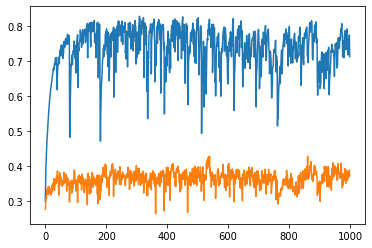

In [78]:
history = model3.fit(train_generator, validation_data=validation_generator,
          steps_per_epoch=300, epochs=1000, validation_steps=100)
model3.evaluate(validation_generator, steps=500)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
# That one wasn't any better, oh well.
# Current record: 38.72% 
# I'll have to see if I can do better preprocessing to get better accuracy.
# I may also want to add extra data from the lower quality files if I can filter out the noise well enough.
# I may also want to decrease the number of classes.
# It would also be a good idea to do stratified sampling of the dataset.
